In [1]:
from rabies.utils import recover_3D,recover_4D
import numpy as np
import SimpleITK as sitk
import pathlib  # Better path manipulation
import nilearn.plotting
import pandas as pd
import matplotlib.pyplot as plt
import glob

bold_file = 'sub-015_ses-1_task-rest_acq-EPI_bold_combined.nii.gz'
confounds_file = 'sub-015_ses-1_task-rest_acq-EPI_bold_combined_confounds.csv'
FD_file = 'sub-015_ses-1_task-rest_acq-EPI_bold_combined_FD_file.csv'

from rabies.visualization import otsu_scaling, plot_3d
template_file='/home/gabriel/.local/share/rabies/EPI_template.nii.gz'
scaled = otsu_scaling(template_file)

brain_mask_file = 'sub-001_ses-1_task-rest_acq-EPI_bold_EPI_brain_mask.nii.gz'
brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(brain_mask_file))
volume_indices = brain_mask.astype(bool)

prior_file='melodic_IC_resampled_resampled.nii.gz'
all_IC_vectors = sitk.GetArrayFromImage(sitk.ReadImage(prior_file))[:,volume_indices]


230810-16:57:37,306 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.0


/home/gabriel/miniconda3/envs/rabies_analysis_repro/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from rabies.confound_correction_pkg.utils import temporal_censoring,lombscargle_fill, exec_ICA_AROMA,butterworth, phase_randomized_regressors, smooth_image, remove_trend, select_confound_timecourses
from rabies.analysis_pkg.analysis_functions import closed_form

def preproc_timeseries(timeseries, brain_mask_file, WM_mask,CSF_mask,vascular_mask, confounds_file, FD_file, mask_conf_list=[], conf_list=[], TR=1.0, highpass=None, lowpass=None, edge_cutoff=30, detrending_order='linear',
                      FD_censoring=True, FD_threshold=0.05, DVARS_censoring=True, minimum_timepoint=120, match_number_timepoints=False, smoothing_filter=0.3):


    if TR=='auto':
        TR = float(data_img.GetSpacing()[3])
    else:
        TR = float(TR)


    '''
    #1 - Compute and apply frame censoring mask (from FD and/or DVARS thresholds)
    '''
    if len(conf_list)>0:
        confounds_array = select_confound_timecourses(conf_list,confounds_file,FD_file)
    else:
        confounds_array = select_confound_timecourses(['mot_6'],confounds_file,FD_file)
    
    FD_trace = pd.read_csv(FD_file).get('Mean')
    
    
    frame_mask,FD_trace,DVARS = temporal_censoring(timeseries, FD_trace, 
            FD_censoring, FD_threshold, DVARS_censoring, minimum_timepoint)
    if frame_mask is None:
        return None

    '''
    #2 - If --match_number_timepoints is selected, each scan is matched to the defined minimum_timepoint number of frames.
    '''
    if match_number_timepoints:
        if (not highpass is None) or (not lowpass is None):
            # if frequency filtering is applied, avoid selecting timepoints that would be removed with --edge_cutoff
            num_cut = int(edge_cutoff/TR)
            if not num_cut==0:
                frame_mask[:num_cut]=0
                frame_mask[-num_cut:]=0

                if frame_mask.sum()<int(minimum_timepoint):
                    from nipype import logging
                    log = logging.getLogger('nipype.workflow')
                    log.warning(f"CONFOUND CORRECTION LEFT LESS THAN {str(minimum_timepoint)} VOLUMES. THIS SCAN WILL BE REMOVED FROM FURTHER PROCESSING.")
                    return None

        # randomly shuffle indices that haven't been censored, then remove an extra subset above --minimum_timepoint
        num_timepoints = len(frame_mask)
        time_idx=np.array(range(num_timepoints))
        perm = np.random.permutation(time_idx[frame_mask])
        # selecting the subset of extra timepoints, and censoring them
        subset_idx = perm[minimum_timepoint:]
        frame_mask[subset_idx]=0
        # keep track of the original number of timepoints for tDOF estimation, to evaluate latter if the correction was succesful
        number_extra_timepoints = len(subset_idx)
    else:
        number_extra_timepoints = 0

    timeseries = timeseries[frame_mask]
    confounds_array = confounds_array[frame_mask]

    '''
    #3 - Linear/Quadratic detrending of fMRI timeseries and nuisance regressors
    '''
    # apply detrending, after censoring
    if detrending_order=='linear':
        second_order=False
    elif detrending_order=='quadratic':
        second_order=True
    else:
        raise ValueError(f"--detrending_order must be 'linear' or 'quadratic', not {detrending_order}")

    # save grand mean prior to detrending
    timeseries_ = remove_trend(timeseries, frame_mask, second_order=second_order, keep_intercept=True)
    grand_mean = timeseries_.mean()
    voxelwise_mean = timeseries_.mean(axis=0)

    timeseries = remove_trend(timeseries, frame_mask, second_order=second_order, keep_intercept=False)
    confounds_array = remove_trend(confounds_array, frame_mask, second_order=second_order, keep_intercept=False)


    if (not highpass is None) or (not lowpass is None):
        '''
        #5 - If frequency filtering and frame censoring are applied, simulate data in censored timepoints using the Lomb-Scargle periodogram, 
            as suggested in Power et al. (2014, Neuroimage), for both the fMRI timeseries and nuisance regressors prior to filtering.
        '''
        timeseries_filled = lombscargle_fill(x=timeseries,time_step=TR,time_mask=frame_mask)
        confounds_filled = lombscargle_fill(x=confounds_array,time_step=TR,time_mask=frame_mask)

        '''
        #6 - As recommended in Lindquist et al. (2019, Human brain mapping), make the nuisance regressors orthogonal
            to the temporal filter.
        '''
        confounds_filtered = butterworth(confounds_filled, TR=TR,
                                high_pass=highpass, low_pass=lowpass)

        '''
        #7 - Apply highpass and/or lowpass filtering on the fMRI timeseries (with simulated timepoints).
        '''

        timeseries_filtered = butterworth(timeseries_filled, TR=TR,
                                high_pass=highpass, low_pass=lowpass)

        # correct for edge effects of the filters
        num_cut = int(edge_cutoff/TR)
        if len(frame_mask)<2*num_cut:
            raise ValueError(f"The timeseries are too short to remove {edge_cutoff}sec of data at each edge.")

        if not num_cut==0:
            frame_mask[:num_cut]=0
            frame_mask[-num_cut:]=0


        '''
        #8 - Re-apply the frame censoring mask onto filtered fMRI timeseries and nuisance regressors, taking out the
            simulated timepoints. Edge artefacts from frequency filtering can also be removed as recommended in Power et al. (2014, Neuroimage).
        '''
        # re-apply the masks to take out simulated data points, and take off the edges
        timeseries = timeseries_filtered[frame_mask]
        confounds_array = confounds_filtered[frame_mask]

    if frame_mask.sum()<int(minimum_timepoint):
        from nipype import logging
        log = logging.getLogger('nipype.workflow')
        log.warning(f"CONFOUND CORRECTION LEFT LESS THAN {str(minimum_timepoint)} VOLUMES. THIS SCAN WILL BE REMOVED FROM FURTHER PROCESSING.")
        return None

    for name,mask in zip(['WM_signal','CSF_signal','vascular_signal'],[WM_mask,CSF_mask,vascular_mask]):
        if name in mask_conf_list:
            mask_trace = timeseries[:,mask[volume_indices]].mean(axis=1)
            confounds_array = np.append(confounds_array,mask_trace.reshape(-1,1),axis=1)
    if ('aCompCor_5' in mask_conf_list) or ('aCompCor_percent' in mask_conf_list):
        if ('aCompCor_5' in mask_conf_list) and ('aCompCor_percent' in mask_conf_list):
            raise ValueError(
                "Can't select both the aCompCor_5 and aCompCor_percent options; must pick one.")
        if 'aCompCor_5' in mask_conf_list:
            method='aCompCor_5'
        elif 'aCompCor_percent' in mask_conf_list:
            method='aCompCor_percent'
        else:
            raise

        from sklearn.decomposition import PCA
        combined_mask_idx = (WM_mask+CSF_mask) > 0
        masked_timeseries = timeseries[:,combined_mask_idx[volume_indices]]

        if method == 'aCompCor_percent':
            pca = PCA()
            pca.fit(masked_timeseries)
            explained_variance = pca.explained_variance_ratio_
            cum_var = 0
            num_comp = 0
            # evaluate the # of components to explain 50% of the variance
            while(cum_var <= 0.5):
                cum_var += explained_variance[num_comp]
                num_comp += 1
            from nipype import logging
            log = logging.getLogger('nipype.workflow')
            log.info("Extracting "+str(num_comp)+" components for aCompCorr.")

        elif method == 'aCompCor_5':
            num_comp = 5

        pca = PCA(n_components=num_comp)
        comp_timeseries = pca.fit_transform(masked_timeseries)
        confounds_array = np.append(confounds_array,comp_timeseries,axis=1)

    '''
    #9 - Apply confound regression using the selected nuisance regressors.
    '''
    # voxels that have a NaN value are set to 0
    nan_voxels = np.isnan(timeseries).sum(axis=0)>1
    timeseries[:,nan_voxels] = 0

    # estimate the VE from the CR selection, or 6 rigid motion parameters if no CR is applied
    X=confounds_array
    Y=timeseries
    try:
        predicted = X.dot(closed_form(X,Y))
        res = Y-predicted
    except:
        from nipype import logging
        log.warning("SINGULAR MATRIX ERROR DURING CONFOUND REGRESSION. THIS SCAN WILL BE REMOVED FROM FURTHER PROCESSING.")

        return None


    VE_spatial = 1-(res.var(axis=0)/Y.var(axis=0))
    VE_temporal = 1-(res.var(axis=1)/Y.var(axis=1))
        
    if len(conf_list) > 0:
        # if confound regression is applied
        timeseries = res
        
    # apply the frame mask to FD trace/DVARS
    DVARS = DVARS[frame_mask]
    FD_trace = FD_trace[frame_mask]

    # calculate temporal degrees of freedom left after confound correction
    num_timepoints = frame_mask.sum()
    aroma_rm = 0
    num_regressors = confounds_array.shape[1]
    tDOF = num_timepoints - (aroma_rm+num_regressors) + number_extra_timepoints

    data_dict = {'timeseries':timeseries, 'global_variance':timeseries.std(), 'temporal_std' : timeseries.std(axis=0), 'predicted_std':predicted.std(axis=0), 'VE_spatial':VE_spatial, 'grand_mean':grand_mean, 'voxelwise_mean':voxelwise_mean, 'FD_trace':FD_trace, 'DVARS':DVARS, 'frame_mask':frame_mask, 'confounds_array':confounds_array, 'tDOF':tDOF}
    
    return data_dict


In [3]:

sub = pathlib.Path(
    bold_file).name.rsplit(".nii")[0]
print(sub)

sub_dict={}
sub_dict['bold_file'] = bold_file
sub_dict['confounds_file'] = confounds_file
sub_dict['FD_file'] = FD_file

data_img = sitk.ReadImage(bold_file, sitk.sitkFloat32)
data_array = sitk.GetArrayFromImage(data_img)
num_volumes = data_array.shape[0]
raw_timeseries = np.zeros([num_volumes, volume_indices.sum()])
for i in range(num_volumes):
    raw_timeseries[i, :] = (data_array[i, :, :, :])[volume_indices]

highpass=0.01
lowpass=None
minimum_timepoint=666
conf_list = ['mot_6']
mask_conf_list=[]
WM_mask=brain_mask
CSF_mask=brain_mask
vascular_mask=brain_mask
sub_dict['preproc_dict'] = preproc_timeseries(raw_timeseries, brain_mask_file, WM_mask,CSF_mask,vascular_mask, confounds_file, FD_file, mask_conf_list=mask_conf_list,conf_list=conf_list, TR=1.0, highpass=highpass, lowpass=lowpass, edge_cutoff=30, detrending_order='linear', 
                  FD_censoring=True, FD_threshold=0.05, DVARS_censoring=False, minimum_timepoint=minimum_timepoint, match_number_timepoints=False, smoothing_filter=0.3)


sub-015_ses-1_task-rest_acq-EPI_bold_combined


/home/gabriel/miniconda3/envs/rabies_analysis_repro/lib/python3.9/site-packages/rabies/confound_correction_pkg/utils.py:144: RuntimeWarning: overflow encountered in square
  DVARS=np.sqrt((derivative**2).mean(axis=1))
/home/gabriel/miniconda3/envs/rabies_analysis_repro/lib/python3.9/site-packages/rabies/confound_correction_pkg/utils.py:301: RuntimeWarning: invalid value encountered in true_divide
  y /= y[time_mask].std(axis=0)
<ipython-input-2-15d551409045>:188: RuntimeWarning: invalid value encountered in true_divide
  VE_spatial = 1-(res.var(axis=0)/Y.var(axis=0))


In [4]:

def closed_form(X, Y, intercept=False):  # functions that computes the Least Squares Estimates
    if intercept:
        X = np.concatenate((X, np.ones([X.shape[0], 1])), axis=1)
    return np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y)


def dual_regression(all_IC_vectors, timeseries):
    ### compute dual regression
    ### Here, we adopt an approach where the algorithm should explain the data
    ### as a linear combination of spatial maps. The data itself, is only temporally
    ### detrended, and not spatially centered, which could cause inconsistencies during
    ### linear regression according to https://mandymejia.com/2018/03/29/the-role-of-centering-in-dual-regression/#:~:text=Dual%20regression%20requires%20centering%20across%20time%20and%20space&text=time%20points.,each%20time%20course%20at%20zero
    ### The fMRI timeseries aren't assumed theoretically to be spatially centered, and
    ### this measure would be removing global signal variations which we are interested in.
    ### Thus we prefer to avoid this step here, despite modelling limitations.
    X = all_IC_vectors.T
    Y = timeseries.T
    # for one given volume, it's values can be expressed through a linear combination of the components
    W = closed_form(X, Y, intercept=False).T
    W /= np.sqrt((W ** 2).mean(axis=0)) # the temporal domain is variance-normalized so that the weights are contained in the spatial maps

    # for a given voxel timeseries, it's signal can be explained a linear combination of the component timecourses
    C = closed_form(W, Y.T, intercept=False).T

    S = np.sqrt((C ** 2).mean(axis=0)) # the component variance/scaling is taken from the spatial maps
    C /= S # the spatial maps are variance normalized; the variance is stored in S

    # we thus output a model of the timeseries of the form X = W.dot((S*C).T)
    DR = {'C':C, 'W':W, 'S':S}
    return DR


[ 8  3 14]
[0.33371107 0.33453954 0.56089566]


/home/gabriel/miniconda3/envs/rabies_analysis_repro/lib/python3.9/site-packages/rabies/analysis_pkg/analysis_math.py:8: RuntimeWarning: invalid value encountered in true_divide
  r = r_num/r_den


[0.7512219254173568, 0.7512219254173568]
[0.5691997498712479, 0.18795031028722411]
[0.2966030432334159, 0.26149275119636506]
[0.3057093917179862, 0.21241600024705687]


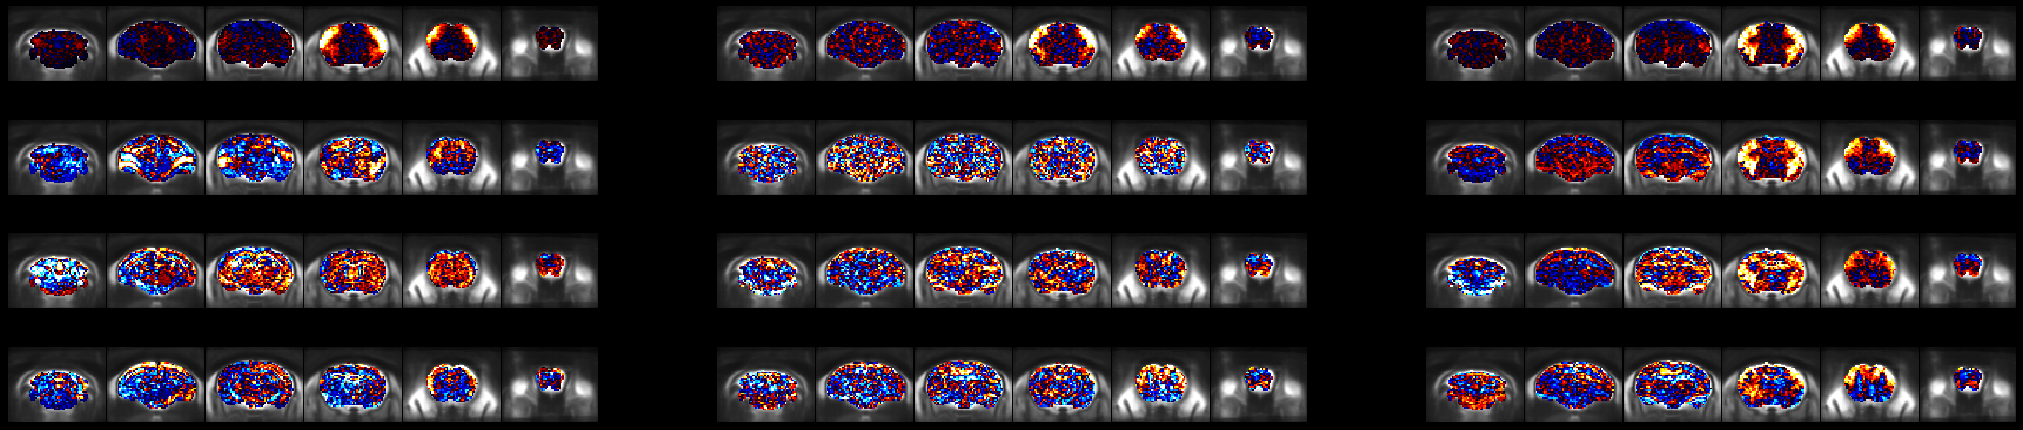

In [6]:
from rabies.analysis_pkg.analysis_math import vcorrcoef

bold_prior_idx = [5,12,19]
bold_prior_idx = [5]
conf_prior_idx = [0, 2, 6, 7, 8, 9, 10, 11, 13, 14, 21, 22, 24, 26, 28, 29]

timeseries = sub_dict['preproc_dict']['timeseries'].copy()
scaling_factor = sub_dict['preproc_dict']['grand_mean']
timeseries = timeseries/scaling_factor
timeseries *= 100 # we scale BOLD in % fluctuations

DR = dual_regression(all_IC_vectors, timeseries)
BOLD_time = DR['W'][:,bold_prior_idx]
confound_time = DR['W'][:,conf_prior_idx]

corr_vector = np.abs(np.corrcoef(BOLD_time.T,confound_time.T)[0,1:])
top_idx = np.argsort(corr_vector)[-3:]
print(top_idx)
print(corr_vector[top_idx])

true_prior = all_IC_vectors[5,:]
true_prior_fit = DR['C'][:,5]
X = timeseries


fig,axes = plt.subplots(nrows=4, ncols=3,figsize=(12*3,2*4))
i=0
for prior,fit_map,y in zip(
                           [all_IC_vectors[5,:],all_IC_vectors[conf_prior_idx][14],all_IC_vectors[conf_prior_idx][3],all_IC_vectors[conf_prior_idx][8]],
                           [DR['C'][:,5],DR['C'][:,conf_prior_idx][:,14],DR['C'][:,conf_prior_idx][:,3],DR['C'][:,conf_prior_idx][:,8]],
                           [DR['W'][:,5],DR['W'][:,conf_prior_idx][:,14],DR['W'][:,conf_prior_idx][:,3],DR['W'][:,conf_prior_idx][:,8]]):

    corr_map = vcorrcoef(X.T, y)
    corr_map[np.isnan(corr_map)] = 0
    #corr_map = closed_form(y.reshape(-1,1),timeseries).flatten()

    #print([np.corrcoef(true_prior_fit,corr_map)[0,1],np.corrcoef(fit_map,corr_map)[0,1]])
    print([np.corrcoef(true_prior,corr_map)[0,1],np.corrcoef(prior,corr_map)[0,1]])

    for map,ax in zip([prior,fit_map,corr_map],axes[i,:]):
        plot_3d([ax], scaled, fig, vmin=0, vmax=1,
                cmap='gray', alpha=1, cbar=False, num_slices=6, planes='coronal')

        sitk_img = recover_3D(
            brain_mask_file, map)

        # select vmax at 95th percentile value
        vector = map.flatten()
        vector.sort()
        vmax = vector[int(len(vector)*0.98)]
        cbar_list = plot_3d([ax], sitk_img, fig, vmax=vmax, vmin=-vmax,
                cmap='cold_hot', alpha=1, cbar=False, num_slices=6, planes='coronal')
    i+=1
